In [1]:
import re
import subprocess
from pathlib import Path

import dolfin as df

import matplotlib as mpl
import matplotlib.cm as mplcmaps
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
import nibabel
import numpy as np
import pyvista as pv
import pandas as pd
import panta_rhei as pr
import seaborn as sns
import simple_mri as sm
import tqdm


from scipy.spatial import distance

from i2m.mri2fenics import dolfin_mesh_to_pyvista_ugrid, dolfin2mri
from gmri2fem.utils import with_suffix
from gmri2fem.visualization import slice_volume, build_image_grid, flatten
from gmri2fem.segmentation_refinement import resample_segmentation

/home/jorgen/programs/miniforge3/envs/gmri2fem/lib/python3.12/site-packages/ufl_legacy/__init__.py:243: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Needed data
- T1w-reference image ffor background
- MRI-concentration image for specific session.
- Processed-concentration image for specific session.
- Dataframe with regionwise concentrations for mesh and processed images at all sessions.
- Regionwise concentration estimates mapped to MRI-format for the chosen session.

In [2]:
res = 32
ses_idx = 3

hdf_path = "../mri_processed_data/sub-01/modeling/resolution32/data.hdf"
mesh_segments_path = "../mri_processed_data/sub-01/modeling/resolution32/mesh_aparc.hdf"
mesh_segments_path = "../mri_processed_data/sub-01/modeling/resolution32/data.hdf"
vtk_path = f"../mri_processed_data/sub-01/modeling/resolution{res}/data.vtu"
t1w_path = "../mri_processed_data/sub-01/registered/sub-01_ses-01_T1w_registered.nii.gz"
seg_path = "../mri_processed_data/fastsurfer/sub-01/mri/aparc+aseg.mgz"
ref_concentration_path = f"../mri_processed_data/sub-01/concentrations/sub-01_ses-{ses_idx:02d}_concentration.nii.gz"

processed_concentrations_dir = f"../mri_processed_data/sub-01/modeling/resolution{res}/"
processed_concentration_path = (
    f"{processed_concentrations_dir}/sub-01_ses-{ses_idx:02d}_concentration-mesh2mri.nii.gz"
)

vtk = pv.read_meshio(vtk_path)
concentration_re = re.compile(r"^concentration-\d+")
concentration_names = [dataname for dataname in list(vtk.point_data) if concentration_re.match(dataname)]
concentration_names
for idx, name in enumerate(tqdm.tqdm(concentration_names)):
    session_output = f'{processed_concentrations_dir}/sub-01_ses-{idx+1:02d}_concentration-mesh2mri.nii.gz'
    if Path(session_output).exists(): continue
    s = subprocess.run(
        "gmri2fem i2m vtk2mri"
        + f" --vtk_path {vtk_path}"
        + f" --data_name {name}"
        + f" --reference_mri {t1w_path}"
        + f" --output '{session_output}'",
        shell=True
    )
    s.check_returncode()

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 46294.75it/s]


In [3]:
t1w_mri = sm.load_mri(t1w_path, dtype=np.single)
ref_mri = sm.load_mri(ref_concentration_path, dtype=np.single)
proc_mri = sm.load_mri(processed_concentration_path, dtype=np.single)

In [4]:
ref = np.where(np.isfinite(proc_mri.data), ref_mri.data, np.nan)
proc = proc_mri.data
error = proc - ref
mask = np.isfinite(ref) * (ref > 1e-6)
error_rel = np.nan * np.zeros_like(error)
error_rel[mask] = error[mask] / np.maximum(1e-8, np.abs(ref[mask]))

[-0.82779729 -0.05224311  0.12737122  1.21188712]


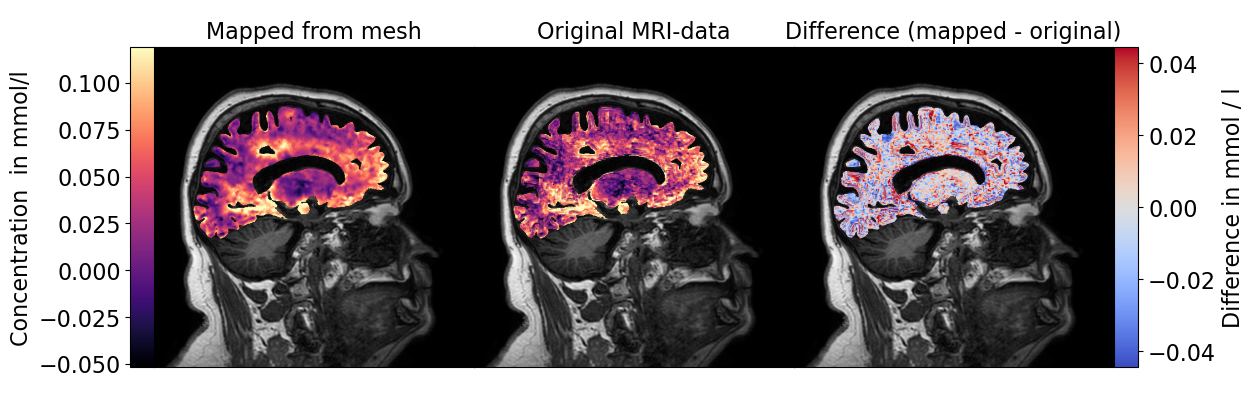

In [5]:
mpl.rc('font', size=16)

grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.05,
    "fig_left_margin": 0.1,
    "fig_right_margin": 0.1,
    "col_top_margin": 0.1,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}


slice_ = ("axial", 300)
slice_ = ("sagittal", 150)
im_t1w = slice_volume(t1w_mri.data, *slice_)
im_ref = slice_volume(ref, *slice_)
im_proc = slice_volume(proc, *slice_)
im_error = slice_volume(error, *slice_)


cmin, cmax = np.nanquantile(im_ref, [0.01, 0.95])
vabs = np.quantile(np.abs(error[np.isfinite(error)]), 0.90)


fig_width = 12
fig, axes = build_image_grid([[im_ref, im_proc, im_error]], grid_config, False)
axes["body"] = flatten(axes["body"])

# Concentrations
norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
axes["fig_left"].axis("on")
cax_bbox = axes["fig_left"].get_position()
cmap = "magma"
cax = fig.add_axes(
    [
        cax_bbox.x0 + cax_bbox.width - 0.02,
        cax_bbox.y0,
        0.02,
        cax_bbox.height,
    ],
    frameon=True
)
cax.yaxis.set_label_position("left")
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label="Concentration  in mmol/l",
    location="left"
)


# vabs = 0.021
error_norm = mpl.colors.Normalize(vmin=-vabs, vmax=vabs)
axes["fig_right"].axis("on")
cax_bbox = axes["fig_right"].get_position()
cmap = mpl.cm.coolwarm
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        0.02,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=error_norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label="Difference in mmol / l",
#     ticks=np.linspace(-0.02, 0.02, 5)
)

axes = axes["body"]
axes[1].imshow(im_t1w, cmap="gray")
axes[1].imshow(im_ref, cmap="magma", vmin=cmin, vmax=cmax)
axes[0].imshow(im_t1w, cmap="gray")
axes[0].imshow(im_proc, cmap="magma", vmin=cmin, vmax=cmax)
axes[2].imshow(im_t1w, cmap="gray")
axes[2].imshow(im_error, cmap="coolwarm", vmin=-vabs, vmax=+vabs)

axes[1].set_title("Original MRI-data", fontsize=16)
axes[0].set_title("Mapped from mesh", fontsize=16)
axes[2].set_title("Difference (mapped - original)", fontsize=16)

print(np.nanquantile(ref, [0, 0.01, 0.95, 1.]))
plt.savefig("../figures/error_interp.pdf", bbox_inches="tight")
plt.savefig("../figures/error_interp.png", bbox_inches="tight")
plt.show()

In [6]:
ref

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [7]:
error

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [17]:
print(np.nanquantile(error, [0., 1.0]))

[-1.10120094  0.79841328]


In [15]:
print(np.nanquantile(np.abs(error), [0.5, 0.9, 1.]))

[7.45058060e-09 2.83843949e-04 5.62287372e-02 1.10120094e+00]


# Grouped Image

In [9]:
def compute_mri_segment_stats(data, seg_mri, label):
    voxelcount = (seg_mri.data == label).sum()
    tracer_amount = np.nansum(data[seg_mri.data == label]) * 0.5**3
    mean_data = np.nanmean(data[seg_mri.data == label])
    median_data = np.nanmedian(data[seg_mri.data == label])

    return {
        "label": label,
        "voxelcount": voxelcount,
        "volume": voxelcount * 0.5**3,
        "tracer_amount": tracer_amount,
        "mean_concentration": mean_data,
        "median_concentration": median_data,
    }

def compute_mri_regionwise_statistics(mri, seg_mri):
    labels = np.unique(seg_mri.data[seg_mri.data > 0])
    records = [
        compute_mri_segment_stats(mri, seg_mri, label)
        for label in map(int, labels)
    ]
    return pd.DataFrame.from_records(records)

def compute_mesh_segment_stats(u, parcellations, dx, label):

    cellcount = (parcellations.array() == label).sum()
    volume = df.assemble(1*dx(int(label)))
    tracer_amount = df.assemble(u * dx(int(label)))
    return {
        "label": label,
        "cellcount": cellcount,
        "volume": volume,
        "tracer_amount": tracer_amount,
        "mean_concentration": tracer_amount / volume
    }

def compute_mesh_regionwise_statistics(u, parcellations):
    parcellation_labels = np.unique(parcellations.array())
    domain = u.function_space().mesh()
    dx = df.Measure("dx", domain=domain, subdomain_data=parcellations)
    records = [
        compute_mesh_segment_stats(u, parcellations, dx, label)
        for label in map(int, parcellation_labels)
    ]
    return pd.DataFrame.from_records(records)

def table_to_dict_map(table, keycolumn: str, valuecolumn: str):
    keys = table[keycolumn]
    assert len(keys) == len(np.unique(keys)), f"keycolumn '{keycolumn}' contains duplicate entries"
    return {
        label: value for label, value in zip(table[keycolumn], table[valuecolumn])
    }

def map_stats_to_segmentation(
        segmentation: np.ndarray,
        table: pd.DataFrame,
        keycolumn: str,
        valuecolumn: str,
    ):
    data = table_to_dict_map(table, keycolumn, valuecolumn)
    labels = data.keys()
    segment_data = np.nan * np.zeros(segmentation.shape)
    for label in labels:
        segment_data[segmentation == label] = data[int(label)]
    return segment_data

In [10]:
seg_mri = resample_segmentation(
    sm.load_mri(seg_path, dtype=np.int16),
    t1w_mri
)

with df.HDF5File(df.MPI.comm_world, str(hdf_path), "r") as hdf:
    domain = pr.read_domain(hdf)
    u = pr.read_function(hdf, "concentration", domain, ses_idx-1)

with df.HDF5File(df.MPI.comm_world, str(mesh_segments_path), "r") as hdf:
    parcellations = df.MeshFunction("size_t", domain, domain.topology().dim())
    hdf.read(parcellations, "parcellations")
    
    
mri_data = compute_mri_regionwise_statistics(ref_mri, seg_mri)
mesh_data = compute_mesh_regionwise_statistics(u, parcellations)
data = mesh_data.merge(mri_data, on=["label"], suffixes=("_mesh", "_mri"))
data["amounts_error"] = data["tracer_amount_mesh"] - data["tracer_amount_mri"]
data["amounts_error_relative"] = data["amounts_error"] / data["tracer_amount_mri"]
data["concentration_error"] = data["mean_concentration_mesh"] - data["mean_concentration_mri"]
data["concentration_error_relative"] = data["concentration_error"] / data["mean_concentration_mri"]
data

,label,cellcount,volume_mesh,tracer_amount_mesh,mean_concentration_mesh,voxelcount,volume_mri,tracer_amount_mri,mean_concentration_mri,median_concentration,amounts_error,amounts_error_relative,concentration_error,concentration_error_relative
0,2,93216,204518.784616,7233.353643,0.035368,1631314,203914.250,7420.986816,0.036393,0.030871,-187.633173,-0.025284,-0.001025,-0.028169
1,10,2639,7694.276805,284.770496,0.037011,50796,6349.500,201.040802,0.031662,0.030021,83.729694,0.416481,0.005348,0.168914
2,11,1588,3806.077793,98.042522,0.025759,25828,3228.500,92.319588,0.028595,0.024870,5.722934,0.061990,-0.002836,-0.099168
3,12,2134,5585.178315,79.701332,0.014270,35168,4396.000,50.575890,0.011505,0.010327,29.125442,0.575876,0.002765,0.240345
4,13,717,2149.571762,9.554702,0.004445,13677,1709.625,5.463465,0.003196,0.002309,4.091237,0.748836,0.001249,0.390906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2029,8764,9265.477627,201.458194,0.021743,77232,9654.000,198.952271,0.020610,0.017251,2.505924,0.012596,0.001133,0.054960
83,2030,6433,12578.543833,964.835112,0.076705,108829,13603.625,1022.078857,0.075145,0.071367,-57.243745,-0.056007,0.001560,0.020754
84,2031,5166,7981.236433,567.126232,0.071057,67630,8453.750,584.939453,0.069199,0.066238,-17.813221,-0.030453,0.001858,0.026856
85,2034,417,704.945941,73.513194,0.104282,5658,707.250,74.748993,0.105690,0.094523,-1.235799,-0.016533,-0.001408,-0.013318


In [11]:
total_volume = data["volume_mesh"].sum()
total_tracer = data["tracer_amount_mesh"].sum()
mean_concentration = total_tracer / total_volume
print(total_volume, total_tracer, mean_concentration)

855948.0776375522 38151.62987919245 0.04457236469820966


In [12]:
segment_mris = {
    "mean_concentration_mesh": np.nan * np.zeros_like(ref_mri.data),
    "mean_concentration_mri": np.nan * np.zeros_like(ref_mri.data),
    "concentration_error": np.nan * np.zeros_like(ref_mri.data),
    "concentration_error_relative": np.nan * np.zeros_like(ref_mri.data),
}
for index, row in data.iterrows():
    for name, mri in segment_mris.items():
        mask = seg_mri.data == row["label"]
        mri[mask] = row[name]

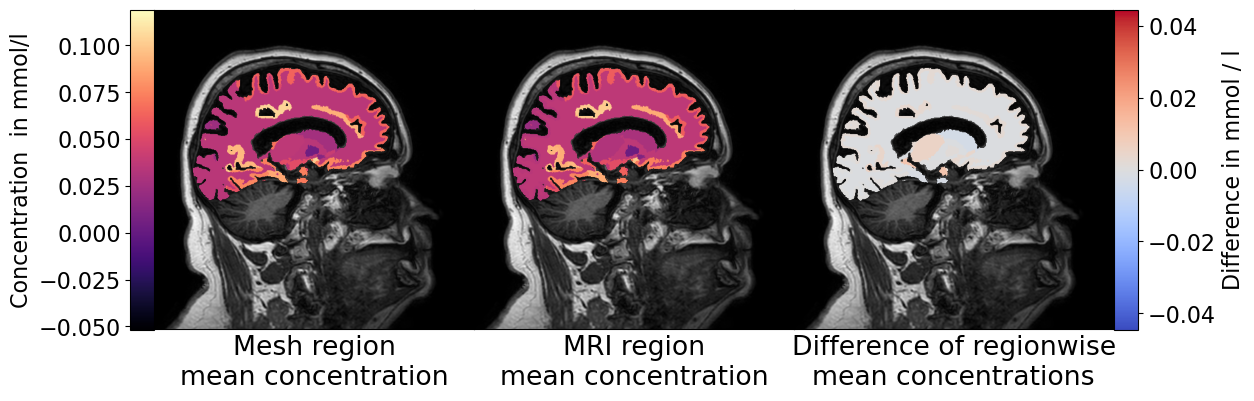

In [13]:
# slice_ = ("axial", 300)
slice_ = ("sagittal", 150)
im_t1w = slice_volume(t1w_mri.data, *slice_)
im_mesh = slice_volume(segment_mris["mean_concentration_mesh"], *slice_)
im_mri = slice_volume(segment_mris["mean_concentration_mri"], *slice_)
im_error = slice_volume(segment_mris["concentration_error"], *slice_)
# im_error = slice_volume(segment_mris["mae_concentration_relative"], *slice_)
# im_error = im_mesh - im_mri


mpl.rc('font', size=16)
grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.05,
    "fig_left_margin": 0.1,
    "fig_right_margin": 0.1,
    "col_top_margin": 0.0,
    "col_bottom_margin": 0.1,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}

fig_width = 12
fig, axes = build_image_grid([[im_mesh, im_mri, im_error]], grid_config, False)
axes["body"] = flatten(axes["body"])

axs = axes["body"]
for ax in axs:
    ax.imshow(im_t1w, cmap="gray")

cmap = "magma"
# cmin, cmax = 0, np.nanmax(segment_mris["mean_concentration_mri"])
concentration_cmap_norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
cax_bbox = axes["fig_left"].get_position()
cax_width = 0.02
cax = fig.add_axes(
    [
        cax_bbox.x0 + cax_bbox.width - cax_width,
        cax_bbox.y0,
        cax_width,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=concentration_cmap_norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label="Concentration  in mmol/l",
    location="left"
)
axs[0].imshow(im_mesh, norm=concentration_cmap_norm, cmap="magma")
axs[1].imshow(im_mri, vmin=cmin, vmax=cmax, cmap="magma")
axs[0].set_title("Mesh region\nmean concentration", y=-0.2)
axs[1].set_title("MRI region\nmean concentration", y=-0.2)
axs[2].set_title("Difference of regionwise\nmean concentrations", y=-0.2)



cmap = "coolwarm"
emax = np.nanquantile(np.abs(segment_mris["concentration_error_relative"]), 1)
emax = np.nanquantile(np.abs(im_error), 1)
error_cmap_norm = mpl.colors.Normalize(vmin=-vabs, vmax=vabs)
cax_bbox = axes["fig_right"].get_position()
cax_width = 0.02
cax = fig.add_axes(
    [
        cax_bbox.x0,
        cax_bbox.y0,
        cax_width,
        cax_bbox.height,
    ],
    frameon=True
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=error_cmap_norm, cmap=cmap),
    cax=cax,
    orientation='vertical',
    label="Difference in mmol / l",
)
axs[2].imshow(im_error, norm=error_cmap_norm, cmap="coolwarm")
plt.savefig("../figures/grouped_errorplot.pdf", bbox_inches="tight")
plt.savefig("../figures/grouped_errorplot.png", bbox_inches="tight")

plt.show()

In [14]:
seg_mri = resample_segmentation(
    sm.load_mri(seg_path, dtype=np.int16),
    t1w_mri
)

with df.HDF5File(df.MPI.comm_world, str(hdf_path), "r") as hdf:
    domain = pr.read_domain(hdf)
    U = [pr.read_function(hdf, "concentration", domain, idx) for idx in range(5)]

with df.HDF5File(df.MPI.comm_world, str(mesh_segments_path), "r") as hdf:
    parcellations = df.MeshFunction("size_t", domain, domain.topology().dim())
    hdf.read(parcellations, "parcellations")

sessions = [f"ses-{idx:02d}" for idx in range(1,6)]

data = []
for session, u in zip(tqdm.tqdm(sessions), U):
    session_mri = sm.load_mri(ref_concentration_path.replace("ses-03", session), dtype=np.single)
    mri_data = compute_mri_regionwise_statistics(session_mri, seg_mri)
    mesh_data = compute_mesh_regionwise_statistics(u, parcellations)
    session_data = mesh_data.merge(mri_data, on=["label"], suffixes=("_mesh", "_mri"))
    session_data["amounts_error"] = session_data["tracer_amount_mesh"] - session_data["tracer_amount_mri"]
    session_data["amounts_error_relative"] = session_data["amounts_error"] / session_data["tracer_amount_mri"]
    session_data["concentration_error"] = session_data["mean_concentration_mesh"] - session_data["mean_concentration_mri"]
    session_data["concentration_error_relative"] = session_data["concentration_error"] / session_data["mean_concentration_mri"]
    session_data["session"] = session
    data.append(session_data)
data = pd.concat(data)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 8))
g = sns.scatterplot(data,
                    x="mean_concentration_mri", y="mean_concentration_mesh", size="volume_mesh",
                hue="session",
                legend=True)

handles, labels = g.get_legend_handles_labels()
plt.legend(handles=handles[1:6], labels=labels[1:6], frameon=False)
# plt.xticks(*plt.yticks())
plt.plot([0, 1e4], [0, 1e4], color="k", ls="--")
plt.xlim(0, 0.12)
plt.ylim(0, 0.12)
plt.yticks(*plt.xticks())


plt.xlabel("Mean concentration in MRI region")
plt.ylabel("Mean concentration in mesh region")
plt.savefig("../figures/i2m_regionwise_scatter.png", bbox_inches="tight")
plt.show()